#### Machine Learning for Pitch Classification

+ Using K-Nearest Neighbors and Random Forest Classifier to classify pitch type based on 2023 pitch data from Statcast.

### Gathering Data

+ I created a function to gather pitch-level data from Statcast for a specified time. For the purpose of this analysis, I will be using pitches from the 2023 season to generate a model to predict pitch type based on ball flight data.
+ The two most important errors when creating the function were as follows:
1. Too Many Values to Unpack Error: Using PyBaseball's pitching_stats function, I was able to get a list of names of FanGraphs-qualified pitchers from the 2023 season. To be used in the get_data() function I created, names had to be separated by first and last name but the string splitting had to be done in a way that mirrored the format in Statcast's data.
2. Out-of-Bounds Single Positional Indexer Error: I did a bunch of digging in an attempt to remedy this error but didn't find much that would allow me to work through it. Doing my best with my current skill level and acknowledging I would still have tens of thousands of data points to work with, I chose to skip over names that incurred this error using the try-except method. Names such a Pablo Lopez or Nestor Cortes (and a handful of others) would result in error even when trying to individually load Statcast data. 

In [2]:
from pybaseball import statcast_pitcher, playerid_lookup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pybaseball import pitching_stats
from datetime import datetime

In [3]:
#Simple function to create a one-step process to retrieve pitch-level data 
def get_data(last_name, first_name, start_date, end_date):
    id_df = playerid_lookup(last_name, first_name)
    id = id_df['key_mlbam'].iloc[0]
    data = statcast_pitcher(start_date, end_date, player_id = id)
    return data

In [5]:
def season_pitch_data(start_date, end_date):
    
    start_year = datetime.strptime(start_date, '%Y-%m-%d').year
    end_year = datetime.strptime(end_date, '%Y-%m-%d').year
    # Fetch pitching stats data
    pitching_stats_data = pitching_stats(start_year, end_year, qual=1)
    
    # Extract player names
    player_names = pitching_stats_data['Name'].tolist()
    
    # Initialize an empty list to hold dataframes
    df = []

    # Process each player name
    for full_name in player_names:
        
        parts = full_name.split()
        first_name = parts[0]
        last_name = ' '.join(parts[1:])
# Run get_data for each player
        try:
            player_data = get_data(last_name, first_name, start_date, end_date)
            if not player_data.empty:
                df.append(player_data)
        except Exception as e:
            print(f"Error retrieving data for {full_name}: {e}")
        
    # Concatenate all dataframes into one
    all_pitches = pd.concat(df, ignore_index=True)
    
    return all_pitches

+ Data was compiled, sampled to ensure it matched my desired output, then saved to a CSV to avoid needing to run the function again as it took quite a while to execute. 

### Data Prep

In [42]:
#Loading packages
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [6]:
#Loading Data
df = pd.read_csv('/Users/will/Documents/Portfolio/all_pitches.csv')

In [8]:
#Keep only necessary columns
df = df[['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 
                           'ax', 'ay', 'az', 'release_spin_rate', 'release_extension', 'spin_axis']]

In [10]:
df.shape

(626411, 15)

In [12]:
#check for null values
for col in df.columns:
    print(f'{col}: {df[col].isnull().sum()}')

pitch_type: 904
release_speed: 904
release_pos_x: 904
release_pos_z: 904
pfx_x: 904
pfx_z: 904
vx0: 904
vy0: 904
vz0: 904
ax: 904
ay: 904
az: 904
release_spin_rate: 4462
release_extension: 1903
spin_axis: 4462


In [14]:
#There are so many datapoints in this dataset that we can drop all rows with null values - less than 1% of data will be lost
#The importance eeping the critical metrics of spin rate and axis greatly outweights the minimal loss in data
df.dropna(axis =0, inplace = True)

In [16]:
df.shape

(621626, 15)

In [18]:
df['pitch_type'].value_counts()

pitch_type
FF    200123
SL    107589
SI     92246
CH     65233
FC     49650
CU     42477
ST     33034
FS     14358
KC     13347
SV      1012
FA       954
FO       766
EP       479
KN       190
SC        74
CS        52
PO        42
Name: count, dtype: int64

In [20]:
#removing Eephus (EP) and pitch-out (PO), FA (which I believe is an outdated code for 4-seam fastball, but we'll remove them for now), 
# SC and KN because of their very low frequency in the data (presented issue when running cross validation for find optimal number of 
# neighbors), and CS (gotta find out what that is)
data = df.loc[~df['pitch_type'].isin(['EP', 'PO', 'FA', 'SC', 'CS', 'KN'])].copy()
data['pitch_type'].value_counts()

pitch_type
FF    200123
SL    107589
SI     92246
CH     65233
FC     49650
CU     42477
ST     33034
FS     14358
KC     13347
SV      1012
FO       766
Name: count, dtype: int64

In [22]:
#Initialize encoder then encode pitch_type (Y)
label_encoder = LabelEncoder()
data['pitch_type_enc'] = label_encoder.fit_transform(data['pitch_type'])

### K-Nearest Neighbors

In [27]:
#check for outliers
from scipy import stats
def find_outliers(data):
    z_scores = stats.zscore(data)
    threshold = 3
    outliers = (abs(z_scores) > threshold).any(axis=1)
    return outliers

In [31]:
#separating features by data type to remove outliers, then recombining them into a single, clean dataframe

num_data = data[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 
                 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension', 'spin_axis']]
cat_data = data[['pitch_type_enc']]

outliers = find_outliers(num_data)

clean_num = num_data[~outliers]
clean_cat = cat_data[~outliers]

clean_data = pd.concat([clean_cat, clean_num], axis = 1)

In [33]:
from sklearn.preprocessing import StandardScaler

#define features
features = clean_data[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 
                           'ax', 'ay', 'az', 'release_spin_rate', 'release_extension', 'spin_axis']]

#using the standard scaler since we must scale data to effecitvely run KNN model
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

In [35]:
#scaling the data turns it into a numpy array, so we're gonna change it to a pandas df
scaled_df = pd.DataFrame(scaled_data, columns = features.columns)

In [37]:
#define features
X = scaled_df
y = clean_data['pitch_type_enc']

In [39]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

#initialize KNN
knn = KNeighborsClassifier()

In [43]:
#set the range of neighbor values we want to test
param_dist = {'n_neighbors': randint(1, 21)}

#run Randomized Search Cross Validation to find optimal number of neighbors
random_search = RandomizedSearchCV(estimator = knn, param_distributions = param_dist, n_iter = 10, cv = 5, scoring = 'accuracy')

#traiing our model
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x164b84350>},
                   scoring='accuracy')

In [45]:
#Get the optimal number of neighbors
optimal_neighbors = random_search.best_params_['n_neighbors']
optimal_neighbors

9

In [47]:
#Get the RSCV accuracy score for our optimal number of neighbors
best_score = random_search.best_score_
best_score

0.9275640436439214

In [51]:
#taking a look at the output of our RSCV 
cvresults = pd.DataFrame(random_search.cv_results_)
cvresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.311351,0.013300,37.827979,1.236384,9,{'n_neighbors': 9},0.928660,0.927538,0.928099,0.927322,0.926200,0.927564,0.000825,1
1,0.307524,0.007892,42.750139,0.718058,14,{'n_neighbors': 14},0.926607,0.925366,0.926464,0.925114,0.924553,0.925621,0.000793,7
2,0.307749,0.011213,35.928161,0.247709,9,{'n_neighbors': 9},0.928660,0.927538,0.928099,0.927322,0.926200,0.927564,0.000825,1
3,0.301700,0.002437,28.191475,0.272183,4,{'n_neighbors': 4},0.923957,0.922740,0.923301,0.922584,0.921796,0.922876,0.000724,10
4,0.303629,0.005479,34.934453,0.364692,8,{'n_neighbors': 8},0.928433,0.926428,0.927467,0.926618,0.925472,0.926884,0.001001,4
5,0.300383,0.002576,37.198525,0.273107,10,{'n_neighbors': 10},0.927825,0.926333,0.927180,0.926415,0.925425,0.926635,0.000814,5
6,0.299653,0.001422,44.322746,0.414095,17,{'n_neighbors': 17},0.925139,0.924435,0.924566,0.924147,0.924386,0.924535,0.000331,8
7,0.298135,0.001805,35.852001,0.189860,9,{'n_neighbors': 9},0.928660,0.927538,0.928099,0.927322,0.926200,0.927564,0.000825,1
8,0.302612,0.005147,47.283512,1.094012,20,{'n_neighbors': 20},0.923838,0.923241,0.923253,0.922978,0.923288,0.923320,0.000282,9
9,0.298582,0.001935,37.220450,0.133509,10,{'n_neighbors': 10},0.927825,0.926333,0.927180,0.926415,0.925425,0.926635,0.000814,5


In [53]:
#saving our top model to be used on our test data
best_knn = random_search.best_estimator_

In [55]:
#predicting values using the test data
y_predicted = best_knn.predict(X_test)

In [57]:
#checking the accuracy score of the model
accuracy = accuracy_score(y_test, y_predicted)
print(accuracy)

0.9308312724194016


In [61]:
#classification report to show breakdown of model performance on each class/pitch type
knn_classification_report = classification_report(y_test, y_predicted, target_names = label_encoder.classes_)
print(knn_classification_report)

              precision    recall  f1-score   support

          CH       0.95      0.95      0.95     18949
          CU       0.91      0.92      0.92     11739
          FC       0.88      0.86      0.87     14710
          FF       0.97      0.98      0.97     59284
          FO       0.97      0.65      0.78        52
          FS       0.84      0.74      0.79      2837
          KC       0.88      0.85      0.86      4026
          SI       0.95      0.93      0.94     26734
          SL       0.90      0.92      0.91     31373
          ST       0.89      0.85      0.87      9538
          SV       0.94      0.71      0.81       290

    accuracy                           0.93    179532
   macro avg       0.92      0.85      0.88    179532
weighted avg       0.93      0.93      0.93    179532



+ With an accuracy score of .93, this model performs very well at classifying pitch type.
+ Forkballs (FO) had a large disparity between precision and recall. The model's precision - correctness of positive classification - shows us that when the model did classify a pitch as a forkball, it did so with a high degree of accuracy. However, the low recall scores tells us that the model had a lot of false negatives when classifying forkballs. This could be explained by the very, very low number of observations of forkballs in the dataset.
+ Similar results, though to a lesser degree, were seen with splitters and slurves. Again, very few observations of these pitch types were seen in the data. 

### Random Forest Classifier

In [24]:
#defining features before splitting data
X = data[['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 
                           'ax', 'ay', 'az', 'release_spin_rate', 'release_extension', 'spin_axis']]
y = data['pitch_type_enc']

In [26]:
#split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)

In [32]:
#fitting the model on the training data
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [34]:
y_predicted = rf.predict(X_test)

In [90]:
accuracy = accuracy_score(y_test, y_predicted)
precision = precision_score(y_test, y_predicted, average = None)
recall = recall_score(y_test, y_predicted, average = None)

print('Accuracy Score: ', accuracy)

Accuracy Score:  0.923764862786433


In [92]:
#grabbing the class name (pitch type) for each class number
class_names = label_encoder.classes_

#Precision and Recall score were calculated for each pitch_type then added to a df with corresponding pitch_type
precision_default = pd.DataFrame({'Pitch' : class_names, 
                                'Precision' : precision})

recall_default = pd.DataFrame({'Pitch' : class_names, 
                                'Recall' : recall})

print(f'\n {precision_default}')
print(f'\n {recall_default}')


    Pitch  Precision
0     CH   0.941476
1     CU   0.901655
2     FC   0.867252
3     FF   0.964887
4     FO   0.960894
5     FS   0.906965
6     KC   0.928010
7     SI   0.953302
8     SL   0.861857
9     ST   0.875365
10    SV   0.977778

    Pitch    Recall
0     CH  0.958972
1     CU  0.909861
2     FC  0.794409
3     FF  0.979114
4     FO  0.751092
5     FS  0.799213
6     KC  0.759406
7     SI  0.940195
8     SL  0.916330
9     ST  0.845898
10    SV  0.558730


In [46]:
#Running RandomSearchCV to see if we can improve the model 
#set dictionary to hyperparamters to be iterated through
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_param_dist = {'n_estimators': randint(10, 100), 
                 'max_depth': randint(1,20)}

#run Randomized Search Cross Validation to find optimal number of neighbors
rf_random_search = RandomizedSearchCV(estimator = rf, param_distributions = rf_param_dist, n_iter = 10, cv = 5, scoring = 'accuracy')

#traiing our model
rf_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1543b2360>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x154f6b1a0>},
                   scoring='accuracy')

In [48]:
#displaying the best paramters from our random search
rf_random_search.best_params_

{'max_depth': 19, 'n_estimators': 54}

In [50]:
#saving best model from above
rf_best = rf_random_search.best_estimator_

In [52]:
y_pred = rf_best.predict(X_test)

In [88]:
#evaluating model performance
rf_best_acc = accuracy_score(y_test, y_pred)
rf_best_prec = precision_score(y_test, y_pred, average = None)
rf_best_rec = recall_score(y_test, y_pred, average = None)

print('Accuracy Score: ', rf_best_acc)

Accuracy Score:  0.9109442810202688


In [120]:
#grabbing the class name (pitch type) for each class number
class_names = label_encoder.classes_

#Precision and Recall score were calculated for each pitch_type then added to a df with corresponding pitch_type
precision_scores = pd.DataFrame({'Pitch' : class_names, 
                                'Precision' : rf_best_prec})

recall_scores = pd.DataFrame({'Pitch' : class_names, 
                                'Recall' : rf_best_rec})

print(f'\n Precision Scores for Best Model \n{precision_scores}')
print(f'\n Recall Scores for Best Model \n{recall_scores}')


 Precision Scores for Best Model 
   Pitch  Precision
0     CH   0.933641
1     CU   0.888686
2     FC   0.841284
3     FF   0.961009
4     FO   0.971098
5     FS   0.906301
6     KC   0.917100
7     SI   0.950713
8     SL   0.831598
9     ST   0.844035
10    SV   0.987805

 Recall Scores for Best Model 
   Pitch    Recall
0     CH  0.956586
1     CU  0.884536
2     FC  0.751843
3     FF  0.977450
4     FO  0.733624
5     FS  0.772811
6     KC  0.698267
7     SI  0.933068
8     SL  0.901928
9     ST  0.821407
10    SV  0.514286


+ Compared to the KNN, we see similar differences between precision and recall for uncommon pitches such as forkballs and slurves. However, this RF model had a much lower recall score for knuckle-curves. The model also had more difficulty classifying cutters comapred to KNN.
+ Overall, it seems that despite comparable accuracy scores, the RF model was more inconsistent than the KNN model above.

In [84]:
#visualizing feature importance 
feature_importances = pd.Series(rf_best.feature_importances_, index=X_train.columns).sort_values(ascending = False)

<Axes: >

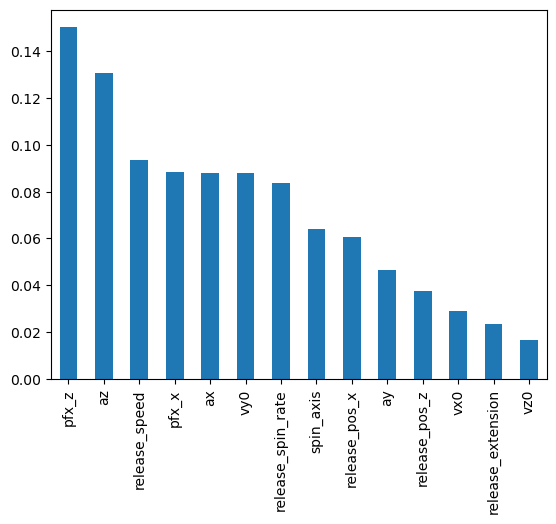

In [86]:
feature_importances.plot.bar()

+ The plot above displays which features were most influential in determining how to assign each pitch to a class.
+ The movement profile of the pitch logically makes sense to be very critical when assigning class - pfx_z (vertical movement) and pfx_x (horizontal movement)
+ The high importance of vertical acceleration (az) makes sense as well and is best shown by looking at two ends of the spectrum in terms of ball flight - four-seam fastballs and curveballs. Below I have displayed mean az based on pitch type. We see that four-seam fastballs have by far the lowest negative accleration and curveballs (both traditional and knuckle) have the highest. Four-seams experience a lesser effective of gravity - 'ride' or 'carry' is an important characteristic in evaluating a four-seamer - while curveballs are defined by their negative vertical movement - the sharper, the better.
+ My assumption for why the default random foresst model had higher scores is that I limited tree depth with running RandomSearchCV. I would expect increasing the max_depth range would yield better results but both models preformed well and the difference in performance was not too drastic. 

In [112]:
data.groupby('pitch_type')[['pfx_x', 'pfx_z', 'ax', 'az']].agg('mean')

,pfx_x,pfx_z,ax,az
pitch_type,,,,
CH,-0.401311,0.476715,-4.797058,-26.693398
CU,0.325279,-0.815342,2.773324,-39.348702
FC,0.137140,0.649323,1.002770,-24.041200
FF,-0.268571,1.311930,-4.079124,-14.758715
FO,-0.604399,0.109112,-6.976237,-30.336147
FS,-0.876045,0.265751,-10.461539,-28.711471
KC,0.452394,-0.776867,3.807374,-39.392367
SI,-0.575110,0.649209,-7.973198,-23.392337
SL,0.253385,0.125312,2.146757,-30.409769
